In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from diffusion_equation import compute_solution
from time import time
from tqdm import trange
import pandas as pd
from sklearn.metrics import r2_score
import torch
from torch import nn
from torchvision import models

In [2]:
DEVICE = 'mps'

In [3]:
def flat_the_gradient_from_loss(model, loss):
    model.zero_grad()
    loss.backward(retain_graph=True)
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.detach().cpu().numpy().reshape(-1))
    grad_flat = np.concatenate(grads)
    return grad_flat

def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum


    # model.zero_grad()

    return w_ic, w_pde, w_data


# Getting data from simulator

In [4]:
# configuration of simulator
# and parametrs of reservouir
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000

t_final = 3.0
dt = t_final / niter

In [5]:
nx0, nx1

(64, 64)

In [6]:
pwat, poil, kwat, koil

(2.0, 4.0, 1.0, 0.3)

In [7]:
# sample_num = 200
# niter = 100
# t_final = 3.0
# dt = t_final / niter

# # press, swat, soil, 
# # pwat, poil, kwat, koil

# sim_data = np.zeros((niter * sample_num, 3))

# x_points = np.zeros((niter * sample_num))
# y_points = np.zeros((niter * sample_num))
# t_points = np.zeros((niter * sample_num))

# pwats = np.zeros((niter * sample_num))
# poils = np.zeros((niter * sample_num))
# kwats = np.zeros((niter * sample_num))
# koils = np.zeros((niter * sample_num))

# vr = 1 / 3

# for sample_index in trange(1, sample_num + 1):
    
#     pwat = 2 + np.random.random() * 4
#     poil = 2 + np.random.random() * 4
#     kwat = 0.5 * np.random.random() + 0.5
#     koil = 0.4 * np.random.random() + 0.1
    
# #     pres, swat, soil = compute_solution(perm, poro,
# #                                         dx0, dx1, dx2, t_final, niter,
# #                                         pwat, kwat, poil, koil, vr,
# #                                         pmin=0.0, pmax=1.0)
        
#     x_list = np.random.randint(size=niter, low=0, high=64)
#     y_list = np.random.randint(size=niter, low=0, high=64)
#     dt_n = np.random.randint(size=niter, low=0, high=niter)
    
#     x_points[(sample_index - 1) * niter: sample_index * niter] = x_list
#     y_points[(sample_index - 1) * niter: sample_index * niter] = y_list
#     t_points[(sample_index - 1) * niter: sample_index * niter] = dt_n
    
#     pwats[(sample_index - 1) * niter: sample_index * niter] = pwat
#     poils[(sample_index - 1) * niter: sample_index * niter] = poil
#     kwats[(sample_index - 1) * niter: sample_index * niter] = kwat
#     koils[(sample_index - 1) * niter: sample_index * niter] = koil

#     for i in range(niter):
#         sim_data[i + (sample_index - 1) * niter, 0] = pres[x_list[i], y_list[i], 0, dt_n[i]]
#         sim_data[i + (sample_index - 1) * niter, 1] = swat[x_list[i], y_list[i], 0, dt_n[i]]
#         sim_data[i + (sample_index - 1) * niter, 2] = soil[x_list[i], y_list[i], 0, dt_n[i]]
        
# N = niter

# np.savetxt(f"data_100_nonlinear/sim_{N}.txt", sim_data)

# np.savetxt(f"data_100_nonlinear/x_{N}.txt", x_points)
# np.savetxt(f"data_100_nonlinear/y_{N}.txt", y_points)
# np.savetxt(f"data_100_nonlinear/t_{N}.txt", t_points)

# np.savetxt(f"data_100_nonlinear/pwat_{N}.txt", pwats)
# np.savetxt(f"data_100_nonlinear/poil_{N}.txt", poils)
# np.savetxt(f"data_100_nonlinear/kwat_{N}.txt", kwats)
# np.savetxt(f"data_100_nonlinear/koil_{N}.txt", koils)

# Read from file

In [8]:
sim_nidexes = np.random.randint(0, 30000, 5000)

In [9]:
# sim_data: pres, swat, soil

sim_data = np.loadtxt("data_100_nonlinear/sim_100.txt", dtype=np.float32)[sim_nidexes]

x_list = np.loadtxt("data_100_nonlinear/x_100.txt", dtype=np.float32)[sim_nidexes]
y_list = np.loadtxt("data_100_nonlinear/y_100.txt", dtype=np.float32)[sim_nidexes]
t_list = np.loadtxt("data_100_nonlinear/t_100.txt", dtype=np.float32)[sim_nidexes]

pwat_list = np.loadtxt("data_100_nonlinear/pwat_100.txt", dtype=np.float32)[sim_nidexes]
poil_list = np.loadtxt("data_100_nonlinear/poil_100.txt", dtype=np.float32)[sim_nidexes]
kwat_list = np.loadtxt("data_100_nonlinear/kwat_100.txt", dtype=np.float32)[sim_nidexes]
koil_list = np.loadtxt("data_100_nonlinear/koil_100.txt", dtype=np.float32)[sim_nidexes]

In [10]:
sim_data.shape

(5000, 3)

In [11]:
perm.shape

(64, 64, 1)

# Convert to torch tensor

In [12]:
simulation_data = torch.tensor(sim_data).requires_grad_(True)

x = torch.tensor(x_list * dx0).requires_grad_(True)
y = torch.tensor(y_list * dx1).requires_grad_(True)
t = torch.tensor(t_list * dt).requires_grad_(True)


pwat = torch.tensor(pwat_list)
poil = torch.tensor(poil_list)
kwat = torch.tensor(kwat_list)
koil = torch.tensor(koil_list)

points = torch.stack((t, x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

In [13]:
points.shape

torch.Size([5000, 7])

# Boundary points

In [14]:
pd.DataFrame(data=points.cpu().detach().numpy(), columns=['t', 'x', 'y', 'pwat', 'poil', 'kwat', 'koil']).describe()

,t,x,y,pwat,poil,kwat,koil
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.029575,0.489966,0.492978,2.016249,3.969793,15.371053,15.077959
std,0.017203,0.289651,0.285861,0.278935,0.559568,8.421176,8.188314
min,0.000000,0.000000,0.000000,1.501701,3.005682,1.204434,1.009385
25%,0.015000,0.250000,0.250000,1.772725,3.494541,8.434031,8.687350
50%,0.029400,0.484375,0.500000,2.041989,3.944211,15.769983,14.533257
75%,0.044400,0.734375,0.734375,2.266103,4.430557,22.243668,21.562063
max,0.059400,0.984375,0.984375,2.495593,4.994729,29.771601,29.902391


In [15]:
pres0_x1_points = torch.stack(
    (t, torch.zeros_like(x), y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

pres1_x1_points = torch.stack(
    (t, torch.ones_like(x), y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

swat0_x1_points = torch.stack(
    (torch.zeros_like(t), x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

soil0_x1_points = torch.stack(
    (torch.zeros_like(t), x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

u0_x2_points = torch.stack(
    (t, x, torch.zeros_like(y), pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

u1_x2_points = torch.stack(
    (t, x, torch.ones_like(y), pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

# Model configuration

In [33]:
# #define the class PINN
# ## input = (x, y, t, pwat, poil, pwat, kwat)
# class pinn_model(nn.Module):
#     def __init__(self, input_layer = 7, hidden_layer = 128, number_layers = 16, output_layer = 7):
#         super().__init__()
#         self.relu = nn.ReLU()
#         self.relu6 = nn.ReLU6()
        
#         self.fcs = nn.Sequential(*
#             [
#                 nn.Linear(input_layer, hidden_layer),
#                 nn.BatchNorm1d(hidden_layer),
#                 nn.ReLU()
#             ]
#         )
        
#         self.fch = nn.Sequential(*
#             [
#                 nn.Sequential(*
#                     [
#                         nn.Linear(hidden_layer, hidden_layer),
#                         nn.Dropout(p=0.2),
#                         nn.ReLU()
#                     ]
#                 ) for _ in range(number_layers - 1)
#             ]
#         )
        
        
#     def forward(self, x):
#         """
#         function for updating neural network
        
#         return:
#             x - vector (pres
#                         soil
#                         swat
#                         uoil_x,  
#                         uoil_y,
#                         uwat_x,  
#                         uwat_y)
#         """
        
#         x = self.fcs(x)
#         x = self.fch(x)     
#         # x = self.fce(x)
#         x = self.relu(x)
        
#         return x

class pinn_model(nn.Module):
    def __init__(self, input_layer=7, hidden_layer=64, number_layers=5, output_layer=7):
        super(pinn_model, self).__init__()
        
        # Simplified model with fewer layers and smaller hidden layer size
        self.hidden_layer = hidden_layer
        
        # Initial layer
        self.fcs = nn.Sequential(
            nn.Linear(input_layer, hidden_layer),
            nn.ReLU()
        )
        
        # Reduced number of hidden layers
        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_layer, hidden_layer),
                nn.ReLU()  # Removed batch normalization and dropout to reduce complexity
            )
            for _ in range(number_layers - 1)
        ])
        
        # Output layer (use Softplus to ensure strictly positive outputs)
        self.fc_out = nn.Linear(hidden_layer, output_layer)
        
        # Weight initialization (Xavier Initialization for better convergence)
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initializes the weights using Xavier Initialization for better convergence."""
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)  # Xavier for better weight scaling
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, input_layer)
        
        Returns:
            x: Output tensor of shape (batch_size, output_layer)
        """
        # Pass through the first layer
        x = self.fcs(x)
        
        # Pass through hidden layers (no skip connections for simplicity)
        for layer in self.fch:
            x = layer(x)
        
        # Final output layer (using Softplus to enforce positive output)
        x = self.fc_out(x)
        x = F.softplus(x)  # Ensuring the output is strictly positive
        return x


draft

<!-- 

# Differentiail equations, Loss function difinition

$$k_{water} = 1, k_{oil} = 0.3$$
$$x = (x_1, x_2)$$
$$ \phi(x) = 0.1 (poro)\\
k(x) = 1 (perm)$$

#### System of equation:

\begin{equation}
    \begin{cases}
        r_1(t, x) = 0.1 \frac{\partial s_{\text{water}}(t, x)}{\partial t} + div(u_{water}) = 0 \\
        r_2(t, x) = 0.1 \frac{\partial s_{\text{oil}}(t, x)}{\partial t} + div(u_{oil}) = 0 \\
        r_{3,x_1}(t, x) = u_{\text{water},x_1} + \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{3,x_2}(t, x) = u_{\text{water},x_2} + \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_{4, x_1}(t, x) = u_{\text{oil},x_1} + 0.1 \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{4, x_2}(t, x) = u_{\text{oil},x_2} + 0.1 \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_5(t, x) = s_{\text{water}}(t, x) + s_{\text{oil}}(t, x) - 1 = 0 \\
    \end{cases}
\end{equation}

#### Boundary condition
\begin{equation}
    \begin{cases}
        P(t, (0, x_2)) = (1, 1) \\
        P(t, (1, x_2)) = (0, 0) \\
        s_{\text{water}}(0, x) = (0, 0) \\
        s_{\text{oil}}(0, x) = (1, 1) \\
        u_{water/ oil}^{x_2}(t, x)\big|_{x_2=0} = u_{water/ oil}^{x_2}(t, x)\big|_{x_2=1} = 0
    \end{cases}
\end{equation}


#### Loss function:

\begin{equation}
    \label{eq:loss_term_0}
    \mathcal{R}_0(t, x) = r_1(t, x)^2 + r_2(t, x)^2 + r_3(t, x)^2 + r_4(t, x)^2 + r_5(t, x)^2
\end{equation}


\begin{equation}
    \label{eq:loss_term_1}
    \mathcal{R}_1(t, x) = \big(p(t, 0) - 1.0\big)^2 + \big(p(t, 1) - 0.0 \big)^2 + \big( s_{\text{oil}}(0, x) - 1.0 \big)^2 + \big( s_{\text{water}}(0, x) - 0.0 \big)^2
\end{equation}

\begin{split}
        \mathcal{R}_2(t, x) = \big( p_{\text{neural network}}(t, x) - p_{\text{simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{water, neural network}}(t, x) - s_{\text{water, simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{oil, neural network}}(t, x) - s_{\text{oil, simulation}}(t, x)\big)^2
\end{split}

#### Resultant function:

\begin{equation}
    \label{eq:loss_final}
    \mathcal{L} = w_0 \frac{1}{N} \mathcal{R}_0(t_i, x_i) + w_1 \frac{1}{N} \mathcal{R}_1(t_i, x_i) + w_2 \frac{1}{N} \mathcal{R}_2(t_i, x_i)
\end{equation} -->

# Model training

In [28]:
# new version
# Initialize model, optimizer, and loss functions
model = pinn_model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
max_dist = float('inf')

# Training loop
max_dist = float('inf')
epochs = 10_000

for cur_epoch in trange(epochs):
    optimizer.zero_grad()
    
    # Forward pass: Get the model's predictions
    model_res = model(points).requires_grad_(True)
    
    # Boundary condition calculations
    press0 = model(pres0_x1_points)[:, 0].requires_grad_(True)
    press1 = model(pres1_x1_points)[:, 0].requires_grad_(True)
    soil0 = model(soil0_x1_points)[:, 1].requires_grad_(True)
    swat0 = model(swat0_x1_points)[:, 2].requires_grad_(True)
    
    # Other boundary conditions (velocity, etc.)
    uwat0_x2 = model(u0_x2_points)[:, 4].requires_grad_(True)
    uwat1_x2 = model(u1_x2_points)[:, 4].requires_grad_(True)
    uoil0_x2 = model(u0_x2_points)[:, 6].requires_grad_(True)
    uoil1_x2 = model(u1_x2_points)[:, 6].requires_grad_(True)
    
    # Vector of ones and zeros
    one_vector = torch.ones_like(model_res[:, 0])
    
    # Functions for r(t, x, y) for different conditions
    r1 = 0.1 * torch.autograd.grad(model_res[:, 2], t, 
                                   one_vector, 
                                   create_graph=True)[0].to(DEVICE) +\
    torch.autograd.grad(model_res[:, 5], x, 
                        one_vector, 
                        create_graph=True)[0].to(DEVICE) +\
    torch.autograd.grad(model_res[:, 6], y, 
                        one_vector, 
                        create_graph=True)[0].to(DEVICE)
    
    
    r2 = 0.1 * torch.autograd.grad(model_res[:, 1], t, 
                                   one_vector, 
                                   create_graph=True)[0].to(DEVICE) +\
    torch.autograd.grad(model_res[:, 3], x, 
                        one_vector, 
                        create_graph=True)[0].to(DEVICE) +\
    torch.autograd.grad(model_res[:, 4], y, 
                        one_vector, 
                        create_graph=True)[0].to(DEVICE)
    
    
    
    r3_x1 = model_res[:, 5] + points[:, 5] * perm_vec * model_res[:, 2]**points[:, 3] * (torch.autograd.grad(model_res[:, 0], 
                                                               x, one_vector, 
                                                               create_graph=True)[0].to(DEVICE))
    
    r3_x2 = model_res[:, 6] + points[:, 5] * perm_vec * model_res[:, 2]**points[:, 3] * (torch.autograd.grad(model_res[:, 0], 
                                                               y, one_vector, 
                                                               create_graph=True)[0].to(DEVICE))

    r4_x1 = model_res[:, 3] + points[:, 6] * (1/3) * perm_vec * model_res[:, 2]**points[:, 4] * (torch.autograd.grad(model_res[:, 0], 
                                                                             x, one_vector, 
                                                                             create_graph=True)[0].to(DEVICE))
    
    r4_x2 = model_res[:, 4] + points[:, 6] * (1/3) * perm_vec  * model_res[:, 2]**points[:, 4] * (torch.autograd.grad(model_res[:, 0], 
                                                                             y, one_vector, 
                                                                             create_graph=True)[0].to(DEVICE))
    
    r5 = model_res[:, 2] + model_res[:, 1] - one_vector
    
    # Losses
    loss0 = torch.mean(r1 ** 2 + r2 ** 2 + r3_x1 ** 2 + r3_x2 ** 2 + r4_x1 ** 2 + r4_x2 ** 2 + r5 ** 2).requires_grad_(True)
    loss1 = torch.mean((press0 - one_vector) ** 2 + press1 ** 2 + (soil0 - one_vector) ** 2 + swat0 ** 2).requires_grad_(True)
    loss2 = torch.mean((model_res[:, 0] - simulation_data[:, 0].to(DEVICE)) ** 2 + 
                       (model_res[:, 2] - simulation_data[:, 1].to(DEVICE)) ** 2 + \
                       (model_res[:, 1] - simulation_data[:, 2].to(DEVICE)) ** 2).requires_grad_(True)
    
    # Compute dynamic weights for the losses
    w_ic, w_pde, w_data = compute_weights_grad_orthogonal_autograd(model, loss1, loss0, loss2)
    
    # Combine losses with weights
    loss = w_ic * loss0 + w_pde * loss1 + w_data * loss2
    dist = loss0 + loss1 + loss2
    loss.backward()
    optimizer.step()
    
    # Print and save model
    if cur_epoch % 20 == 0:
        text = f"Epoch: {cur_epoch}, Loss: {float(loss.cpu().detach().numpy()):.4e}, " + \
               f"Loss0: {float(loss0.cpu().detach().numpy()):.4e}, Loss1: {float(loss1.cpu().detach().numpy()):.4e}, " + \
               f"Loss2: {float(loss2.cpu().detach().numpy()):.4e}"
        print(text)
    if dist.cpu().detach().numpy() < max_dist:
        torch.save(model.state_dict(), 'pinn_deep_model3_best.pth')
        max_dist = dist.cpu().detach().numpy()
    
    if cur_epoch % 3000 == 0:
        optimizer.param_groups[0]['lr'] /= 2  # Reduce learning rate after some epochs

  0%|                                                                                                               | 2/10000 [00:00<1:01:31,  2.71it/s]

Epoch: 0, Loss: 1.1990e+01, Loss0: 1.1991e+01, Loss1: 2.9589e+00, Loss2: 2.4728e+00


  0%|▏                                                                                                               | 22/10000 [00:03<29:07,  5.71it/s]

Epoch: 20, Loss: 1.0158e-01, Loss0: 7.4791e-02, Loss1: 5.1849e-01, Loss2: 1.3152e-01


  0%|▍                                                                                                               | 42/10000 [00:07<23:16,  7.13it/s]

Epoch: 40, Loss: 2.0251e-02, Loss0: 8.5095e-03, Loss1: 5.0346e-01, Loss2: 1.1815e-01


  1%|▋                                                                                                               | 62/10000 [00:09<23:10,  7.15it/s]

Epoch: 60, Loss: 1.0934e-02, Loss0: 3.2906e-03, Loss1: 4.9116e-01, Loss2: 1.1515e-01


  1%|▉                                                                                                               | 82/10000 [00:12<23:06,  7.15it/s]

Epoch: 80, Loss: 3.5649e-03, Loss0: 1.9691e-03, Loss1: 4.7752e-01, Loss2: 1.1219e-01


  1%|█▏                                                                                                             | 102/10000 [00:15<23:09,  7.12it/s]

Epoch: 100, Loss: 3.9389e-03, Loss0: 1.4565e-03, Loss1: 4.4415e-01, Loss2: 1.0588e-01


  1%|█▎                                                                                                             | 122/10000 [00:18<22:53,  7.19it/s]

Epoch: 120, Loss: 2.3588e-02, Loss0: 1.4145e-03, Loss1: 3.1866e-01, Loss2: 8.1824e-02


  1%|█▌                                                                                                             | 142/10000 [00:21<22:44,  7.23it/s]

Epoch: 140, Loss: 2.7330e-02, Loss0: 1.6707e-03, Loss1: 5.4969e-01, Loss2: 1.9750e-01


  2%|█▊                                                                                                             | 162/10000 [00:23<22:19,  7.35it/s]

Epoch: 160, Loss: 3.0457e-03, Loss0: 2.1275e-03, Loss1: 9.7464e-01, Loss2: 3.4672e-01


  2%|██                                                                                                             | 182/10000 [00:26<22:46,  7.19it/s]

Epoch: 180, Loss: 3.6282e-02, Loss0: 5.3833e-03, Loss1: 4.8898e-01, Loss2: 1.2893e-01


  2%|██▏                                                                                                            | 202/10000 [00:29<22:34,  7.23it/s]

Epoch: 200, Loss: 2.2232e-02, Loss0: 3.7422e-03, Loss1: 4.2889e-01, Loss2: 1.0642e-01


  2%|██▍                                                                                                            | 222/10000 [00:32<22:11,  7.35it/s]

Epoch: 220, Loss: 1.9413e-02, Loss0: 2.5836e-03, Loss1: 3.0383e-01, Loss2: 7.8910e-02


  2%|██▋                                                                                                            | 242/10000 [00:35<22:36,  7.20it/s]

Epoch: 240, Loss: 1.8751e-02, Loss0: 3.0486e-03, Loss1: 8.6138e-02, Loss2: 3.3557e-02


  3%|██▉                                                                                                            | 262/10000 [00:37<22:05,  7.35it/s]

Epoch: 260, Loss: 1.9513e-02, Loss0: 3.0510e-03, Loss1: 9.0967e-02, Loss2: 3.3652e-02


  3%|███▏                                                                                                           | 282/10000 [00:40<24:33,  6.60it/s]

Epoch: 280, Loss: 8.6555e-03, Loss0: 2.9958e-03, Loss1: 4.6324e-02, Loss2: 1.6355e-02


  3%|███▎                                                                                                           | 302/10000 [00:43<23:17,  6.94it/s]

Epoch: 300, Loss: 8.4839e-03, Loss0: 2.2763e-03, Loss1: 2.2472e-02, Loss2: 1.3142e-02


  3%|███▌                                                                                                           | 322/10000 [00:46<22:35,  7.14it/s]

Epoch: 320, Loss: 4.0716e-03, Loss0: 1.8519e-03, Loss1: 1.9588e-02, Loss2: 9.5787e-03


  3%|███▊                                                                                                           | 342/10000 [00:49<22:43,  7.08it/s]

Epoch: 340, Loss: 2.2975e-03, Loss0: 1.5415e-03, Loss1: 1.6896e-02, Loss2: 8.3889e-03


  4%|████                                                                                                           | 362/10000 [00:52<22:32,  7.12it/s]

Epoch: 360, Loss: 1.9229e-03, Loss0: 1.3457e-03, Loss1: 1.7817e-02, Loss2: 7.5267e-03


  4%|████▏                                                                                                          | 382/10000 [00:55<22:28,  7.13it/s]

Epoch: 380, Loss: 1.6044e-03, Loss0: 1.1814e-03, Loss1: 1.6114e-02, Loss2: 6.9846e-03


  4%|████▍                                                                                                          | 402/10000 [00:57<22:43,  7.04it/s]

Epoch: 400, Loss: 1.4445e-03, Loss0: 1.0612e-03, Loss1: 1.4951e-02, Loss2: 6.5523e-03


  4%|████▋                                                                                                          | 422/10000 [01:00<22:44,  7.02it/s]

Epoch: 420, Loss: 1.3015e-03, Loss0: 9.5516e-04, Loss1: 1.3778e-02, Loss2: 6.1364e-03


  4%|████▉                                                                                                          | 442/10000 [01:03<22:30,  7.08it/s]

Epoch: 440, Loss: 1.1355e-03, Loss0: 8.6201e-04, Loss1: 1.2767e-02, Loss2: 5.7731e-03


  5%|█████▏                                                                                                         | 462/10000 [01:06<22:28,  7.07it/s]

Epoch: 460, Loss: 1.0346e-03, Loss0: 7.9041e-04, Loss1: 1.1797e-02, Loss2: 5.4459e-03


  5%|█████▎                                                                                                         | 482/10000 [01:09<22:33,  7.03it/s]

Epoch: 480, Loss: 9.6392e-04, Loss0: 7.3542e-04, Loss1: 1.0827e-02, Loss2: 5.1354e-03


  5%|█████▌                                                                                                         | 502/10000 [01:12<22:20,  7.08it/s]

Epoch: 500, Loss: 8.9534e-04, Loss0: 6.8737e-04, Loss1: 9.8783e-03, Loss2: 4.8680e-03


  5%|█████▊                                                                                                         | 522/10000 [01:15<22:12,  7.11it/s]

Epoch: 520, Loss: 8.0759e-04, Loss0: 6.4661e-04, Loss1: 8.5517e-03, Loss2: 4.6349e-03


  5%|██████                                                                                                         | 542/10000 [01:17<22:05,  7.13it/s]

Epoch: 540, Loss: 7.6499e-04, Loss0: 6.1153e-04, Loss1: 7.7178e-03, Loss2: 4.4199e-03


  6%|██████▏                                                                                                        | 562/10000 [01:20<22:20,  7.04it/s]

Epoch: 560, Loss: 7.1884e-04, Loss0: 5.8279e-04, Loss1: 7.0097e-03, Loss2: 4.2328e-03


  6%|██████▍                                                                                                        | 582/10000 [01:23<22:18,  7.04it/s]

Epoch: 580, Loss: 6.6133e-04, Loss0: 5.5583e-04, Loss1: 6.3003e-03, Loss2: 4.0736e-03


  6%|██████▋                                                                                                        | 602/10000 [01:26<22:20,  7.01it/s]

Epoch: 600, Loss: 7.0953e-04, Loss0: 5.3152e-04, Loss1: 5.7063e-03, Loss2: 3.9348e-03


  6%|██████▉                                                                                                        | 622/10000 [01:29<22:11,  7.04it/s]

Epoch: 620, Loss: 5.9514e-04, Loss0: 5.0819e-04, Loss1: 5.1783e-03, Loss2: 3.8134e-03


  6%|███████▏                                                                                                       | 642/10000 [01:32<22:11,  7.03it/s]

Epoch: 640, Loss: 5.7173e-04, Loss0: 4.8613e-04, Loss1: 4.7787e-03, Loss2: 3.7079e-03


  7%|███████▎                                                                                                       | 662/10000 [01:35<22:49,  6.82it/s]

Epoch: 660, Loss: 5.3342e-04, Loss0: 4.6577e-04, Loss1: 4.4611e-03, Loss2: 3.6179e-03


  7%|███████▌                                                                                                       | 682/10000 [01:38<22:13,  6.99it/s]

Epoch: 680, Loss: 5.1223e-04, Loss0: 4.4588e-04, Loss1: 4.2210e-03, Loss2: 3.5427e-03


  7%|███████▊                                                                                                       | 702/10000 [01:41<22:39,  6.84it/s]

Epoch: 700, Loss: 4.8698e-04, Loss0: 4.2791e-04, Loss1: 4.0230e-03, Loss2: 3.4747e-03


  7%|████████                                                                                                       | 722/10000 [01:44<21:58,  7.04it/s]

Epoch: 720, Loss: 4.7633e-04, Loss0: 4.1238e-04, Loss1: 3.8542e-03, Loss2: 3.4093e-03


  7%|████████▏                                                                                                      | 742/10000 [01:46<21:35,  7.15it/s]

Epoch: 740, Loss: 4.5442e-04, Loss0: 3.9660e-04, Loss1: 3.7308e-03, Loss2: 3.3463e-03


  8%|████████▍                                                                                                      | 762/10000 [01:49<21:51,  7.05it/s]

Epoch: 760, Loss: 4.5757e-04, Loss0: 3.8194e-04, Loss1: 3.5571e-03, Loss2: 3.2867e-03


  8%|████████▋                                                                                                      | 782/10000 [01:52<22:16,  6.90it/s]

Epoch: 780, Loss: 4.1207e-04, Loss0: 3.6672e-04, Loss1: 3.4301e-03, Loss2: 3.2317e-03


  8%|████████▉                                                                                                      | 802/10000 [01:55<22:03,  6.95it/s]

Epoch: 800, Loss: 3.9963e-04, Loss0: 3.5253e-04, Loss1: 3.3074e-03, Loss2: 3.1798e-03


  8%|█████████                                                                                                      | 822/10000 [01:58<21:42,  7.05it/s]

Epoch: 820, Loss: 3.8241e-04, Loss0: 3.3974e-04, Loss1: 3.2094e-03, Loss2: 3.1272e-03


  8%|█████████▎                                                                                                     | 842/10000 [02:01<21:53,  6.97it/s]

Epoch: 840, Loss: 3.6939e-04, Loss0: 3.2765e-04, Loss1: 3.1317e-03, Loss2: 3.0738e-03


  9%|█████████▌                                                                                                     | 862/10000 [02:04<21:43,  7.01it/s]

Epoch: 860, Loss: 3.5275e-04, Loss0: 3.1416e-04, Loss1: 2.9980e-03, Loss2: 3.0245e-03


  9%|█████████▊                                                                                                     | 882/10000 [02:06<21:53,  6.94it/s]

Epoch: 880, Loss: 3.3484e-04, Loss0: 3.0104e-04, Loss1: 2.8727e-03, Loss2: 2.9796e-03


  9%|██████████                                                                                                     | 902/10000 [02:09<21:43,  6.98it/s]

Epoch: 900, Loss: 3.1986e-04, Loss0: 2.8902e-04, Loss1: 2.7593e-03, Loss2: 2.9396e-03


  9%|██████████▏                                                                                                    | 922/10000 [02:12<21:30,  7.03it/s]

Epoch: 920, Loss: 3.1217e-04, Loss0: 2.7760e-04, Loss1: 2.6687e-03, Loss2: 2.9032e-03


  9%|██████████▍                                                                                                    | 942/10000 [02:15<21:37,  6.98it/s]

Epoch: 940, Loss: 2.9682e-04, Loss0: 2.6666e-04, Loss1: 2.5924e-03, Loss2: 2.8680e-03


 10%|██████████▋                                                                                                    | 962/10000 [02:18<21:31,  7.00it/s]

Epoch: 960, Loss: 2.8484e-04, Loss0: 2.5605e-04, Loss1: 2.5315e-03, Loss2: 2.8334e-03


 10%|██████████▉                                                                                                    | 982/10000 [02:21<21:18,  7.05it/s]

Epoch: 980, Loss: 3.1391e-04, Loss0: 2.4673e-04, Loss1: 2.4496e-03, Loss2: 2.7996e-03


 10%|███████████                                                                                                   | 1002/10000 [02:24<21:15,  7.05it/s]

Epoch: 1000, Loss: 3.6007e-04, Loss0: 2.3874e-04, Loss1: 2.3642e-03, Loss2: 2.7687e-03


 10%|███████████▏                                                                                                  | 1022/10000 [02:26<21:15,  7.04it/s]

Epoch: 1020, Loss: 4.3429e-04, Loss0: 2.3487e-04, Loss1: 2.2422e-03, Loss2: 2.7463e-03


 10%|███████████▍                                                                                                  | 1042/10000 [02:29<21:09,  7.05it/s]

Epoch: 1040, Loss: 3.1776e-04, Loss0: 2.2093e-04, Loss1: 2.2231e-03, Loss2: 2.7049e-03


 11%|███████████▋                                                                                                  | 1062/10000 [02:32<20:45,  7.18it/s]

Epoch: 1060, Loss: 3.3463e-04, Loss0: 2.1445e-04, Loss1: 2.1058e-03, Loss2: 2.6797e-03


 11%|███████████▉                                                                                                  | 1082/10000 [02:35<20:49,  7.14it/s]

Epoch: 1080, Loss: 3.7372e-03, Loss0: 7.4303e-04, Loss1: 6.2870e-03, Loss2: 5.1877e-03


 11%|████████████                                                                                                  | 1102/10000 [02:38<20:52,  7.11it/s]

Epoch: 1100, Loss: 1.7331e-03, Loss0: 5.2466e-04, Loss1: 2.9398e-03, Loss2: 3.7879e-03


 11%|████████████▎                                                                                                 | 1122/10000 [02:41<20:46,  7.12it/s]

Epoch: 1120, Loss: 7.6001e-04, Loss0: 3.0992e-04, Loss1: 2.1178e-03, Loss2: 2.9368e-03


 11%|████████████▌                                                                                                 | 1142/10000 [02:43<20:40,  7.14it/s]

Epoch: 1140, Loss: 3.9764e-04, Loss0: 2.5600e-04, Loss1: 2.1262e-03, Loss2: 2.7991e-03


 12%|████████████▊                                                                                                 | 1162/10000 [02:46<20:44,  7.10it/s]

Epoch: 1160, Loss: 3.0354e-04, Loss0: 2.3146e-04, Loss1: 2.1413e-03, Loss2: 2.7400e-03


 12%|█████████████                                                                                                 | 1182/10000 [02:49<20:42,  7.10it/s]

Epoch: 1180, Loss: 2.5435e-04, Loss0: 2.1813e-04, Loss1: 2.1622e-03, Loss2: 2.6999e-03


 12%|█████████████▏                                                                                                | 1202/10000 [02:52<20:49,  7.04it/s]

Epoch: 1200, Loss: 2.3267e-04, Loss0: 2.0806e-04, Loss1: 2.1430e-03, Loss2: 2.6734e-03


 12%|█████████████▍                                                                                                | 1222/10000 [02:55<20:48,  7.03it/s]

Epoch: 1220, Loss: 2.1934e-04, Loss0: 1.9762e-04, Loss1: 2.1142e-03, Loss2: 2.6505e-03


 12%|█████████████▋                                                                                                | 1242/10000 [02:58<20:52,  6.99it/s]

Epoch: 1240, Loss: 2.0900e-04, Loss0: 1.8833e-04, Loss1: 2.0766e-03, Loss2: 2.6309e-03


 13%|█████████████▉                                                                                                | 1262/10000 [03:00<20:57,  6.95it/s]

Epoch: 1260, Loss: 2.0012e-04, Loss0: 1.8009e-04, Loss1: 2.0466e-03, Loss2: 2.6125e-03


 13%|██████████████                                                                                                | 1282/10000 [03:03<20:50,  6.97it/s]

Epoch: 1280, Loss: 1.9258e-04, Loss0: 1.7287e-04, Loss1: 2.0192e-03, Loss2: 2.5941e-03


 13%|██████████████▎                                                                                               | 1302/10000 [03:06<20:42,  7.00it/s]

Epoch: 1300, Loss: 1.8514e-04, Loss0: 1.6600e-04, Loss1: 2.0008e-03, Loss2: 2.5763e-03


 13%|██████████████▌                                                                                               | 1322/10000 [03:10<24:58,  5.79it/s]

Epoch: 1320, Loss: 1.7794e-04, Loss0: 1.5969e-04, Loss1: 1.9860e-03, Loss2: 2.5586e-03


 13%|██████████████▊                                                                                               | 1342/10000 [03:13<20:47,  6.94it/s]

Epoch: 1340, Loss: 1.7145e-04, Loss0: 1.5378e-04, Loss1: 1.9718e-03, Loss2: 2.5415e-03


 14%|██████████████▉                                                                                               | 1362/10000 [03:16<20:45,  6.94it/s]

Epoch: 1360, Loss: 1.6482e-04, Loss0: 1.4777e-04, Loss1: 1.9510e-03, Loss2: 2.5256e-03


 14%|███████████████▏                                                                                              | 1382/10000 [03:18<20:31,  7.00it/s]

Epoch: 1380, Loss: 1.5841e-04, Loss0: 1.4199e-04, Loss1: 1.9281e-03, Loss2: 2.5106e-03


 14%|███████████████▍                                                                                              | 1402/10000 [03:21<20:41,  6.92it/s]

Epoch: 1400, Loss: 1.5309e-04, Loss0: 1.3697e-04, Loss1: 1.9108e-03, Loss2: 2.4958e-03


 14%|███████████████▋                                                                                              | 1422/10000 [03:24<20:29,  6.98it/s]

Epoch: 1420, Loss: 1.4821e-04, Loss0: 1.3237e-04, Loss1: 1.8939e-03, Loss2: 2.4814e-03


 14%|███████████████▊                                                                                              | 1442/10000 [03:27<22:00,  6.48it/s]

Epoch: 1440, Loss: 1.4331e-04, Loss0: 1.2801e-04, Loss1: 1.8784e-03, Loss2: 2.4672e-03


 15%|████████████████                                                                                              | 1462/10000 [03:30<20:49,  6.83it/s]

Epoch: 1460, Loss: 1.3841e-04, Loss0: 1.2365e-04, Loss1: 1.8600e-03, Loss2: 2.4536e-03


 15%|████████████████▎                                                                                             | 1482/10000 [03:34<24:31,  5.79it/s]

Epoch: 1480, Loss: 1.3384e-04, Loss0: 1.1933e-04, Loss1: 1.8381e-03, Loss2: 2.4409e-03


 15%|████████████████▌                                                                                             | 1502/10000 [03:37<20:33,  6.89it/s]

Epoch: 1500, Loss: 1.2944e-04, Loss0: 1.1544e-04, Loss1: 1.8196e-03, Loss2: 2.4284e-03


 15%|████████████████▋                                                                                             | 1522/10000 [03:40<20:21,  6.94it/s]

Epoch: 1520, Loss: 1.2501e-04, Loss0: 1.1154e-04, Loss1: 1.7997e-03, Loss2: 2.4166e-03


 15%|████████████████▉                                                                                             | 1542/10000 [03:43<22:02,  6.39it/s]

Epoch: 1540, Loss: 1.2081e-04, Loss0: 1.0757e-04, Loss1: 1.7813e-03, Loss2: 2.4056e-03


 16%|█████████████████▏                                                                                            | 1562/10000 [03:46<25:59,  5.41it/s]

Epoch: 1560, Loss: 1.1678e-04, Loss0: 1.0398e-04, Loss1: 1.7646e-03, Loss2: 2.3947e-03


 16%|█████████████████▍                                                                                            | 1582/10000 [03:49<20:38,  6.80it/s]

Epoch: 1580, Loss: 1.1291e-04, Loss0: 1.0054e-04, Loss1: 1.7517e-03, Loss2: 2.3842e-03


 16%|█████████████████▌                                                                                            | 1602/10000 [03:52<20:35,  6.80it/s]

Epoch: 1600, Loss: 1.0925e-04, Loss0: 9.7254e-05, Loss1: 1.7410e-03, Loss2: 2.3741e-03


 16%|█████████████████▊                                                                                            | 1622/10000 [03:55<19:44,  7.07it/s]

Epoch: 1620, Loss: 1.0603e-04, Loss0: 9.4152e-05, Loss1: 1.7281e-03, Loss2: 2.3645e-03


 16%|██████████████████                                                                                            | 1642/10000 [03:58<20:03,  6.95it/s]

Epoch: 1640, Loss: 1.0305e-04, Loss0: 9.1377e-05, Loss1: 1.7147e-03, Loss2: 2.3548e-03


 17%|██████████████████▎                                                                                           | 1662/10000 [04:00<19:59,  6.95it/s]

Epoch: 1660, Loss: 9.9445e-05, Loss0: 8.8498e-05, Loss1: 1.6987e-03, Loss2: 2.3456e-03


 17%|██████████████████▌                                                                                           | 1682/10000 [04:03<19:59,  6.93it/s]

Epoch: 1680, Loss: 9.6090e-05, Loss0: 8.5678e-05, Loss1: 1.6851e-03, Loss2: 2.3370e-03


 17%|██████████████████▋                                                                                           | 1702/10000 [04:06<19:57,  6.93it/s]

Epoch: 1700, Loss: 9.3725e-05, Loss0: 8.3084e-05, Loss1: 1.6766e-03, Loss2: 2.3287e-03


 17%|██████████████████▉                                                                                           | 1722/10000 [04:09<19:43,  7.00it/s]

Epoch: 1720, Loss: 9.0586e-05, Loss0: 8.0580e-05, Loss1: 1.6670e-03, Loss2: 2.3206e-03


 17%|███████████████████▏                                                                                          | 1742/10000 [04:12<20:31,  6.70it/s]

Epoch: 1740, Loss: 9.3308e-05, Loss0: 7.8239e-05, Loss1: 1.6571e-03, Loss2: 2.3128e-03


 18%|███████████████████▍                                                                                          | 1762/10000 [04:15<19:36,  7.00it/s]

Epoch: 1760, Loss: 2.0658e-04, Loss0: 8.1475e-05, Loss1: 1.6299e-03, Loss2: 2.3116e-03


 18%|███████████████████▌                                                                                          | 1782/10000 [04:18<19:08,  7.16it/s]

Epoch: 1780, Loss: 4.8264e-03, Loss0: 3.0509e-03, Loss1: 5.8439e-03, Loss2: 8.7072e-03


 18%|███████████████████▊                                                                                          | 1802/10000 [04:21<19:13,  7.11it/s]

Epoch: 1800, Loss: 2.2817e-02, Loss0: 1.9001e-03, Loss1: 5.7508e-02, Loss2: 2.3739e-02


 18%|████████████████████                                                                                          | 1822/10000 [04:23<19:15,  7.08it/s]

Epoch: 1820, Loss: 3.6381e-03, Loss0: 1.1381e-03, Loss1: 1.3188e-02, Loss2: 6.7369e-03


 18%|████████████████████▎                                                                                         | 1842/10000 [04:26<19:02,  7.14it/s]

Epoch: 1840, Loss: 1.4335e-03, Loss0: 7.2293e-04, Loss1: 3.5259e-03, Loss2: 3.6276e-03


 19%|████████████████████▍                                                                                         | 1862/10000 [04:29<18:58,  7.15it/s]

Epoch: 1860, Loss: 5.5817e-04, Loss0: 4.6358e-04, Loss1: 1.7691e-03, Loss2: 2.7676e-03


 19%|████████████████████▋                                                                                         | 1882/10000 [04:32<19:11,  7.05it/s]

Epoch: 1880, Loss: 3.9756e-04, Loss0: 3.3425e-04, Loss1: 1.6080e-03, Loss2: 2.6507e-03


 19%|████████████████████▉                                                                                         | 1902/10000 [04:35<18:56,  7.13it/s]

Epoch: 1900, Loss: 3.1314e-04, Loss0: 2.6666e-04, Loss1: 1.5702e-03, Loss2: 2.5774e-03


 19%|█████████████████████▏                                                                                        | 1922/10000 [04:37<18:48,  7.16it/s]

Epoch: 1920, Loss: 2.5721e-04, Loss0: 2.2454e-04, Loss1: 1.5165e-03, Loss2: 2.5305e-03


 19%|█████████████████████▎                                                                                        | 1942/10000 [04:40<18:50,  7.13it/s]

Epoch: 1940, Loss: 2.2281e-04, Loss0: 1.9678e-04, Loss1: 1.4884e-03, Loss2: 2.4946e-03


 20%|█████████████████████▌                                                                                        | 1962/10000 [04:43<18:50,  7.11it/s]

Epoch: 1960, Loss: 2.0031e-04, Loss0: 1.7585e-04, Loss1: 1.4632e-03, Loss2: 2.4651e-03


 20%|█████████████████████▊                                                                                        | 1982/10000 [04:46<18:40,  7.16it/s]

Epoch: 1980, Loss: 1.8171e-04, Loss0: 1.5994e-04, Loss1: 1.4420e-03, Loss2: 2.4392e-03


 20%|██████████████████████                                                                                        | 2002/10000 [04:49<19:14,  6.93it/s]

Epoch: 2000, Loss: 1.6684e-04, Loss0: 1.4716e-04, Loss1: 1.4208e-03, Loss2: 2.4165e-03


 20%|██████████████████████▏                                                                                       | 2022/10000 [04:52<19:05,  6.97it/s]

Epoch: 2020, Loss: 1.5477e-04, Loss0: 1.3667e-04, Loss1: 1.4004e-03, Loss2: 2.3986e-03


 20%|██████████████████████▍                                                                                       | 2042/10000 [04:54<18:56,  7.00it/s]

Epoch: 2040, Loss: 1.4499e-04, Loss0: 1.2802e-04, Loss1: 1.3861e-03, Loss2: 2.3826e-03


 21%|██████████████████████▋                                                                                       | 2062/10000 [04:57<18:50,  7.02it/s]

Epoch: 2060, Loss: 1.3672e-04, Loss0: 1.2051e-04, Loss1: 1.3738e-03, Loss2: 2.3676e-03


 21%|██████████████████████▉                                                                                       | 2082/10000 [05:00<18:51,  7.00it/s]

Epoch: 2080, Loss: 1.2912e-04, Loss0: 1.1382e-04, Loss1: 1.3577e-03, Loss2: 2.3531e-03


 21%|███████████████████████                                                                                       | 2102/10000 [05:03<19:02,  6.92it/s]

Epoch: 2100, Loss: 1.2251e-04, Loss0: 1.0820e-04, Loss1: 1.3445e-03, Loss2: 2.3393e-03


 21%|███████████████████████▎                                                                                      | 2122/10000 [05:06<18:59,  6.91it/s]

Epoch: 2120, Loss: 1.1686e-04, Loss0: 1.0321e-04, Loss1: 1.3337e-03, Loss2: 2.3265e-03


 21%|███████████████████████▌                                                                                      | 2142/10000 [05:09<18:51,  6.94it/s]

Epoch: 2140, Loss: 1.1143e-04, Loss0: 9.8359e-05, Loss1: 1.3235e-03, Loss2: 2.3144e-03


 22%|███████████████████████▊                                                                                      | 2162/10000 [05:12<18:59,  6.88it/s]

Epoch: 2160, Loss: 1.0617e-04, Loss0: 9.3724e-05, Loss1: 1.3111e-03, Loss2: 2.3032e-03


 22%|████████████████████████                                                                                      | 2182/10000 [05:15<18:40,  6.98it/s]

Epoch: 2180, Loss: 1.0134e-04, Loss0: 8.9450e-05, Loss1: 1.3053e-03, Loss2: 2.2923e-03


 22%|████████████████████████▏                                                                                     | 2202/10000 [05:18<18:36,  6.99it/s]

Epoch: 2200, Loss: 9.6935e-05, Loss0: 8.5671e-05, Loss1: 1.2983e-03, Loss2: 2.2818e-03


 22%|████████████████████████▍                                                                                     | 2222/10000 [05:20<18:33,  6.98it/s]

Epoch: 2220, Loss: 9.3083e-05, Loss0: 8.2140e-05, Loss1: 1.2887e-03, Loss2: 2.2717e-03


 22%|████████████████████████▋                                                                                     | 2242/10000 [05:23<18:35,  6.95it/s]

Epoch: 2240, Loss: 8.9550e-05, Loss0: 7.8823e-05, Loss1: 1.2851e-03, Loss2: 2.2621e-03


 23%|████████████████████████▉                                                                                     | 2262/10000 [05:26<18:38,  6.92it/s]

Epoch: 2260, Loss: 8.5737e-05, Loss0: 7.5789e-05, Loss1: 1.2809e-03, Loss2: 2.2530e-03


 23%|█████████████████████████                                                                                     | 2282/10000 [05:29<18:35,  6.92it/s]

Epoch: 2280, Loss: 8.2918e-05, Loss0: 7.3092e-05, Loss1: 1.2769e-03, Loss2: 2.2442e-03


 23%|█████████████████████████▎                                                                                    | 2302/10000 [05:32<18:49,  6.82it/s]

Epoch: 2300, Loss: 7.9891e-05, Loss0: 7.0463e-05, Loss1: 1.2722e-03, Loss2: 2.2360e-03


 23%|█████████████████████████▌                                                                                    | 2322/10000 [05:35<18:22,  6.96it/s]

Epoch: 2320, Loss: 7.6772e-05, Loss0: 6.7828e-05, Loss1: 1.2683e-03, Loss2: 2.2281e-03


 23%|█████████████████████████▊                                                                                    | 2342/10000 [05:38<18:52,  6.76it/s]

Epoch: 2340, Loss: 7.4211e-05, Loss0: 6.5445e-05, Loss1: 1.2625e-03, Loss2: 2.2205e-03


 24%|█████████████████████████▉                                                                                    | 2362/10000 [05:41<18:28,  6.89it/s]

Epoch: 2360, Loss: 7.1561e-05, Loss0: 6.3173e-05, Loss1: 1.2557e-03, Loss2: 2.2128e-03


 24%|██████████████████████████▏                                                                                   | 2382/10000 [05:44<18:24,  6.90it/s]

Epoch: 2380, Loss: 6.9401e-05, Loss0: 6.1076e-05, Loss1: 1.2507e-03, Loss2: 2.2055e-03


 24%|██████████████████████████▍                                                                                   | 2402/10000 [05:47<20:28,  6.18it/s]

Epoch: 2400, Loss: 6.7252e-05, Loss0: 5.9028e-05, Loss1: 1.2459e-03, Loss2: 2.1986e-03


 24%|██████████████████████████▋                                                                                   | 2422/10000 [05:50<19:14,  6.56it/s]

Epoch: 2420, Loss: 6.4927e-05, Loss0: 5.7080e-05, Loss1: 1.2418e-03, Loss2: 2.1917e-03


 24%|██████████████████████████▊                                                                                   | 2442/10000 [05:53<17:55,  7.03it/s]

Epoch: 2440, Loss: 6.3286e-05, Loss0: 5.5189e-05, Loss1: 1.2387e-03, Loss2: 2.1852e-03


 25%|███████████████████████████                                                                                   | 2462/10000 [05:56<18:06,  6.94it/s]

Epoch: 2460, Loss: 6.0602e-05, Loss0: 5.3418e-05, Loss1: 1.2350e-03, Loss2: 2.1789e-03


 25%|███████████████████████████▎                                                                                  | 2482/10000 [05:59<18:00,  6.96it/s]

Epoch: 2480, Loss: 5.9127e-05, Loss0: 5.1723e-05, Loss1: 1.2320e-03, Loss2: 2.1726e-03


 25%|███████████████████████████▌                                                                                  | 2502/10000 [06:02<17:55,  6.97it/s]

Epoch: 2500, Loss: 5.7181e-05, Loss0: 5.0132e-05, Loss1: 1.2277e-03, Loss2: 2.1666e-03


 25%|███████████████████████████▋                                                                                  | 2522/10000 [06:05<17:50,  6.99it/s]

Epoch: 2520, Loss: 5.6388e-05, Loss0: 4.8687e-05, Loss1: 1.2251e-03, Loss2: 2.1608e-03


 25%|███████████████████████████▉                                                                                  | 2542/10000 [06:08<17:56,  6.93it/s]

Epoch: 2540, Loss: 5.3626e-05, Loss0: 4.7364e-05, Loss1: 1.2203e-03, Loss2: 2.1551e-03


 26%|████████████████████████████▏                                                                                 | 2562/10000 [06:10<17:45,  6.98it/s]

Epoch: 2560, Loss: 5.2318e-05, Loss0: 4.6149e-05, Loss1: 1.2182e-03, Loss2: 2.1498e-03


 26%|████████████████████████████▍                                                                                 | 2582/10000 [06:13<18:00,  6.86it/s]

Epoch: 2580, Loss: 5.0912e-05, Loss0: 4.5056e-05, Loss1: 1.2145e-03, Loss2: 2.1446e-03


 26%|████████████████████████████▍                                                                                 | 2590/10000 [06:15<17:52,  6.91it/s]


KeyboardInterrupt: 

In [34]:
# # old version

# # neural network returns:
# # x - vector (pres
# #             soil
# #             swat
# #             uoil_x,  
# #             uoil_y,
# #             uwat_x,  
# #             uwat_y)

# # change learning rate if necessary
# # model input - t, x, y, pwat, poil, kwat, koil

# model = pinn_model().to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# loss0_hist = []
# loss1_hist = []
# loss2_hist = []

# w0_hist = []
# w1_hist = []
# w2_hist = []

# # optimizer.param_groups[0]['lr'] = 0.0005
# # perm_vec = torch.tensor(perm[list(x_list.astype(int)), list(y_list.astype(int)), -1])

# max_dist = float('inf')
# perm_vec = torch.tensor(perm[list(x_list.astype(int)), list(y_list.astype(int)), -1], dtype=torch.float32).to(DEVICE)

# epochs = 10_000
# for cur_epoch in trange(epochs):
#     optimizer.zero_grad()
    
#     model_res = model(points).requires_grad_(True)
#     # presseru bound
#     press0 = model(pres0_x1_points)[:, 0].requires_grad_(True)
#     press1 = model(pres1_x1_points)[:, 0].requires_grad_(True)
    
#     # struation boundary
#     soil0 = model(soil0_x1_points)[:, 1].requires_grad_(True)
#     swat0 = model(swat0_x1_points)[:, 2].requires_grad_(True)
    
#     # velocity boundary
#     uwat0_x2 = model(u0_x2_points)[:, 4].requires_grad_(True)
#     uwat1_x2 = model(u1_x2_points)[:, 4].requires_grad_(True)
#     uoil0_x2 = model(u0_x2_points)[:, 6].requires_grad_(True)
#     uoil1_x2 = model(u1_x2_points)[:, 6].requires_grad_(True)
    
#     one_vector = torch.ones_like(model_res[:, 0])
#     zeros_vector = torch.zeros_like(model_res[:, 0])
    
#     # functions r(t,x)
#     r1 = 0.1 * torch.autograd.grad(model_res[:, 2], t, 
#                                    one_vector, 
#                                    create_graph=True)[0].to(DEVICE) +\
#     torch.autograd.grad(model_res[:, 5], x, 
#                         one_vector, 
#                         create_graph=True)[0].to(DEVICE) +\
#     torch.autograd.grad(model_res[:, 6], y, 
#                         one_vector, 
#                         create_graph=True)[0].to(DEVICE)
    
    
#     r2 = 0.1 * torch.autograd.grad(model_res[:, 1], t, 
#                                    one_vector, 
#                                    create_graph=True)[0].to(DEVICE) +\
#     torch.autograd.grad(model_res[:, 3], x, 
#                         one_vector, 
#                         create_graph=True)[0].to(DEVICE) +\
#     torch.autograd.grad(model_res[:, 4], y, 
#                         one_vector, 
#                         create_graph=True)[0].to(DEVICE)
    
    
    
#     r3_x1 = model_res[:, 5] + points[:, 5] * perm_vec * model_res[:, 2]**points[:, 3] * (torch.autograd.grad(model_res[:, 0], 
#                                                                x, one_vector, 
#                                                                create_graph=True)[0].to(DEVICE))
    
#     r3_x2 = model_res[:, 6] + points[:, 5] * perm_vec * model_res[:, 2]**points[:, 3] * (torch.autograd.grad(model_res[:, 0], 
#                                                                y, one_vector, 
#                                                                create_graph=True)[0].to(DEVICE))

#     r4_x1 = model_res[:, 3] + points[:, 6] * (1/3) * perm_vec * model_res[:, 2]**points[:, 4] * (torch.autograd.grad(model_res[:, 0], 
#                                                                              x, one_vector, 
#                                                                              create_graph=True)[0].to(DEVICE))
    
#     r4_x2 = model_res[:, 4] + points[:, 6] * (1/3) * perm_vec  * model_res[:, 2]**points[:, 4] * (torch.autograd.grad(model_res[:, 0], 
#                                                                              y, one_vector, 
#                                                                              create_graph=True)[0].to(DEVICE))
    
#     r5 = model_res[:, 2] + model_res[:, 1] - one_vector
    
    
#     # Loss0
#     loss0 = torch.mean(r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + 
#                        r4_x1**2 + r4_x2**2 + r5**2).requires_grad_(True)
    
#     # Loss1
#     loss1 = torch.mean((press0 - one_vector)**2 + press1**2 + \
#                        (soil0 - one_vector)**2 + swat0**2).requires_grad_(True) 
#     # +\
#     #                    uwat0_x2**2 + uwat1_x2**2 +\
#     #                    uoil0_x2**2 + uoil1_x2**2).requires_grad_(True)

#     # x - vector (pres
#     #             soil
#     #             swat
#     #             uoil_x,  
#     #             uoil_y,
#     #             uwat_x,  
#     #             uwat_y)

#     # Loss2
#     loss2 = torch.mean((model_res[:,0] - simulation_data[:,0].to(DEVICE))**2 + 
#                        (model_res[:,2] - simulation_data[:,1].to(DEVICE))**2 + \
#                        (model_res[:,1] - simulation_data[:,2].to(DEVICE))**2).requires_grad_(True)
    

#     # algo for weights adjustment
#     # l1 = loss1.clone().detach().requires_grad_(True)
#     # l2 = loss2.clone().detach().requires_grad_(True)
#     # l0 = loss0.clone().detach().requires_grad_(True)
#     # l1.backward(retain_graph=True)
#     # l2.backward(retain_graph=True)
#     # l0.backward(retain_graph=True)
#     # w0 = abs(l0 / (l0 + l1 + l2))
#     # w1 = abs(l1 / (l1 + l0 + l2))
#     # w2 = abs(l2 / (l1 + l0 + l2))

#     w0, w1, w2 = compute_weights_grad_orthogonal_autograd(model, loss1, 
#                                                           loss0, loss2, kappa=10.0)
    
    
#     # losses history
#     loss0_hist.append(loss0.cpu().detach().numpy())
#     loss1_hist.append(loss1.cpu().detach().numpy())
#     loss2_hist.append(loss2.cpu().detach().numpy())
    
#     loss = w0*loss0 + w1*loss1 + w2*loss2
#     dist = loss0 + loss1 + loss2
#     loss.backward(retain_graph=True)
#     optimizer.step()
#     if cur_epoch % 3_000:
#         optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 2
#     if dist.cpu().detach().numpy() < max_dist:
#         torch.save(model.state_dict(), 'pinn_deep_model3_best_1k.pth')
#         max_dist = dist.cpu().detach().numpy()
#     if cur_epoch % 20 == 0:
#         text = f'epoch: {cur_epoch}\tloss: {float(dist.cpu().detach().numpy()), float(loss0.cpu().detach().numpy()), float(loss1.cpu().detach().numpy()), float(loss2.cpu().detach().numpy())}\t' 
#         print(text)

In [35]:
# def main(model):
#     pwat = 2.0
#     poil = 4.0
#     vr = 0.3
#     kwat = 1.0
#     koil = 0.3

#     # pwat = 1.0
#     # poil = 1.0
#     # vr = 1.0
#     # kwat = 1.0
#     # koil = 1.0
#     pmin = 0.0
#     pmax = 1.0
#     nx0 = 50
#     nx1 = 30
#     nx2 = 1
#     dx0 = 1.0 / nx0
#     dx1 = 1.0 / nx1
#     dx2 = 1.0 / nx2
#     dt = 0.26e-1
#     niter = 100

#     poro = 0.1 + np.zeros((nx0, nx1, nx2))
#     perm = np.ones((nx0, nx1, nx2))
#     swat = np.zeros((nx0, nx1, nx2))
#     soil = np.ones((nx0, nx1, nx2))


#     pres, swat, soil = compute_solution(perm, poro,
#                                         dx0, dx1, dx2, dt * niter, niter,
#                                         pwat, kwat, poil, koil, vr,
#                                         pmin=0.0, pmax=1.0)
    
#     time_for_model = (niter * dt) * torch.ones(1500)
#     x_for_model = dx0 * torch.arange(50)
#     y_for_model = dx1 * torch.arange(30)
#     cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
#     model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
#     model_prediction = model_prediction.detach().numpy()
    
    
    
#     plt.figure()
#     plt.title('Water saturation, simulator')
#     plt.imshow(swat[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_sim.png', facecolor='b')
#     plt.show()
    
#     plt.figure()
#     plt.title('Water saturation, PINN')
#     plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_pinn.png')
#     plt.show()
    
#     plt.figure()
#     plt.title('Pressure, simulator')
#     plt.imshow(pres[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_sim.png')
#     plt.show()
    

#     plt.figure()
#     plt.title('Pressure, PINN')
#     plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_pinn.png')
#     plt.show()    
    
    
#     plt.figure()
#     plt.title('Насыщенность воды')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Модель')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='Симулятор')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('swat_scatter.png')
#     plt.show()


#     plt.figure()
#     plt.title('Pressure')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Симулятор')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='Модель')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('pres_scatter.png')
#     plt.show()



#     return 0

In [36]:
# main(model)

In [37]:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)


# 0 - pres, 1 - swat, 2 - soil

In [38]:
def main_new(model):
    perm = np.load('perm.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2

    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    pmin = 0.0
    pmax = 1.0

    dt = 0.26e-1
    niter = 100


    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
    model_prediction = model_prediction.detach().numpy()
    
    
    
    plt.figure()
    plt.title('Water saturation, simulator')
    plt.imshow(swat[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_sim.png')
    plt.show()
    
    plt.figure()
    plt.title('Water saturation, PINN')
    plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_pinn.png')
    plt.show()
    
    plt.figure()
    plt.title('Pressure, simulator')
    plt.imshow(pres[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_sim.png')
    plt.show()
    

    plt.figure()
    plt.title('Pressure, PINN')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_pinn.png')
    plt.show()    
    
    
    plt.figure()
    plt.title('Water saturation at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('swat_scatter.png')
    plt.show()


    plt.figure()
    plt.title('Pressure at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('pres_scatter.png')
    plt.show()

    return 0

In [39]:
# main_new(model)

# Test results

In [47]:
model.eval()
model.load_state_dict(torch.load('pinn_deep_model2_best_1k.pth'))

RuntimeError: Error(s) in loading state_dict for pinn_model:
	Missing key(s) in state_dict: "fc_out.weight", "fc_out.bias". 
	Unexpected key(s) in state_dict: "fce.weight", "fce.bias", "fch.4.0.weight", "fch.4.0.bias", "fch.5.0.weight", "fch.5.0.bias", "fch.6.0.weight", "fch.6.0.bias", "fch.7.0.weight", "fch.7.0.bias", "fch.8.0.weight", "fch.8.0.bias", "fch.9.0.weight", "fch.9.0.bias", "fch.10.0.weight", "fch.10.0.bias", "fch.11.0.weight", "fch.11.0.bias", "fch.12.0.weight", "fch.12.0.bias", "fch.13.0.weight", "fch.13.0.bias", "fch.14.0.weight", "fch.14.0.bias". 
	size mismatch for fcs.0.weight: copying a param with shape torch.Size([64, 3]) from checkpoint, the shape in current model is torch.Size([64, 7]).

In [43]:
def set_big_plot_style(scale: float = 1.2):
    """Global matplotlib style for bigger text/ticks/legend and sharper saved figs."""
    base = 18 * scale
    title = 22 * scale
    label = 20 * scale
    ticks = 16 * scale
    legend = 16 * scale

    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,

        "font.size": base,
        "axes.titlesize": title,
        "axes.labelsize": label,
        "xtick.labelsize": ticks,
        "ytick.labelsize": ticks,
        "legend.fontsize": legend,

        "axes.titlepad": 12,
        "axes.labelpad": 10,
    })

def _add_colorbar_big(im):
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=plt.rcParams.get("ytick.labelsize", 16))
    return cbar


    # ---- make ALL plot text bigger ----
set_big_plot_style(scale=1.3)  # try 1.0 .. 1.6

perm = np.load('perm_3sigma.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

dt = 0.15e-1
niter = 100


# swat = np.zeros((nx0, nx1, nx2))
# soil = np.ones((nx0, nx1, nx2))


# pres, swat, soil = compute_solution(perm, poro,
#                                     dx0, dx1, dx2, dt * niter, niter,
#                                     pwat, kwat, poil, koil, vr,
#                                     pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * torch.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1).to('mps'))
model_prediction = model_prediction.cpu().detach().numpy()

    
    
plt.figure()
plt.title('Water saturation, sim')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('third_test/satur_sim_test2.png', bbox_inches="tight")
plt.show()

plt.figure()
plt.title('Water saturation, PINN')
plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('third_test/satur_pinn_test2.png', bbox_inches="tight")
plt.show()

plt.figure()
plt.title('Pressure, sim')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('third_test/pres_sim_test2.png', bbox_inches="tight")
plt.show()


plt.figure()
plt.title('Pressure, PINN')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('third_test/pres_pinn_test2.png', bbox_inches="tight")
plt.show()  

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (4096x3 and 7x64)

In [86]:
metrics = ['MSE', 'MAE', 'R_2', 'RMSE']

satur = [
    np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1])),
    r2_score(swat[:, 0, 0, -1], model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2))**0.5
]


press = [
    np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1])),
    r2_score(pres[:, 0, 0, -1], model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2))**0.5
]

In [87]:
data = pd.DataFrame({'Metrics test': metrics,
                     'Saturation test': satur,
                     'Pressure test': press})

In [88]:
data

,Metrics test,Saturation test,Pressure test
0,MSE,0.000157,0.000220
1,MAE,0.001920,0.004063
2,R_2,0.979666,0.997936
3,RMSE,0.012545,0.014821


# Train results

In [76]:
# Train results
# pres, swat, soil
metrics = ['MSE', 'MAE', 'R_2', 'RMSE']

model_train_pred = model(points).cpu().detach().numpy()
sim_data_train = simulation_data.detach().numpy()

satur = [
    np.mean((model_train_pred[:, 2] - sim_data_train[:, 1]) ** 2),
    abs(np.mean(model_train_pred[:, 2] - sim_data_train[:, 1])),
    r2_score(sim_data_train[:, 1], model_train_pred[:, 2]),
    (np.mean((model_train_pred[:, 2] - sim_data_train[:, 1]) ** 2))**0.5
]


press = [
    np.mean((model_train_pred[:, 0] - sim_data_train[:, 0]) ** 2),
    abs(np.mean(model_train_pred[:, 0] - sim_data_train[:, 0])),
    r2_score(sim_data_train[:, 0], model_train_pred[:, 0]),
    (np.mean((model_train_pred[:, 0] - sim_data_train[:, 0]) ** 2))**0.5
]

In [77]:
data = pd.DataFrame({'Metrics train': metrics,
                     'Saturation train': satur,
                     'Pressure train': press})

data

,Metrics train,Saturation train,Pressure train
0,MSE,0.029610,0.102365
1,MAE,0.086574,0.223145
2,R_2,-0.575527,-0.342077
3,RMSE,0.172075,0.319945


In [45]:
model_prediction[:, 2]

array([ 0.20297553,  0.18941939,  0.17599034, ..., -0.00176622,
       -0.00184536, -0.00193919], dtype=float32)

In [78]:
sim_data_train[:, 1]

array([-5.44713062e-35, -8.53961381e-34, -2.39543708e-36,  2.47118300e-35,
        4.39105915e-35,  5.30774659e-03,  2.26973618e-09,  2.66007066e-01,
       -5.36298139e-33,  3.18020087e-04,  3.65479797e-01, -3.66824767e-34,
        1.91348440e-35,  3.99271786e-01,  3.20196867e-01,  1.07877780e-35,
        2.08822027e-01, -8.84559499e-36,  3.29447573e-33, -2.84698854e-34,
       -7.93899497e-35,  1.23250946e-01,  1.30221533e-05, -2.58770388e-35,
        6.51038363e-06,  6.14137024e-35,  3.61193150e-01, -2.91501440e-33,
        1.37437961e-09,  8.39369092e-03, -1.36051716e-34, -6.81980680e-34,
       -2.80789922e-34, -1.08024698e-33, -5.01120295e-33,  1.43406942e-01,
        1.44964123e-32, -1.35284706e-35,  1.90618164e-34,  3.88702117e-35,
        2.66449305e-34,  2.46853814e-36, -4.73303984e-34, -4.11599347e-35,
       -2.23551108e-34,  4.64662337e-33,  9.76494177e-34,  2.71849036e-01,
        1.36786400e-34, -2.10284184e-34,  3.40055019e-01,  4.20269012e-01,
        1.09593689e-32, -

In [79]:
model_train_pred[:, 2]

array([ 1.70193762e-01,  1.66147351e-01,  8.31827521e-02,  6.08858690e-02,
       -1.91152096e-04,  2.36591399e-01,  1.94048792e-01,  2.43403807e-01,
        1.64687976e-01,  1.91318005e-01,  2.43978798e-01,  1.03926934e-01,
        5.91024756e-03,  2.40260988e-01,  2.43010476e-01,  1.46131217e-03,
        2.37345070e-01,  2.39244878e-01,  2.04917714e-01,  2.29561985e-01,
        1.26147270e-03,  2.36038059e-01,  2.41473317e-01,  7.94987679e-02,
        2.35620886e-01,  2.18681082e-01,  2.37730891e-01,  2.08301157e-01,
        2.19997048e-01,  2.38798305e-01,  2.38406524e-01,  1.59989446e-01,
        2.39027470e-01,  1.90100163e-01,  2.42234007e-01,  2.35784337e-01,
        2.35847861e-01,  1.51500493e-01,  2.37624228e-01,  1.27802640e-02,
        1.82718813e-01,  1.70300901e-03,  2.28362143e-01,  1.27330288e-01,
       -2.06232071e-05,  2.10888177e-01,  5.47388196e-03,  2.46441618e-01,
        4.06682491e-04,  2.17749342e-01,  2.40237534e-01,  2.42527708e-01,
        2.02617109e-01,  

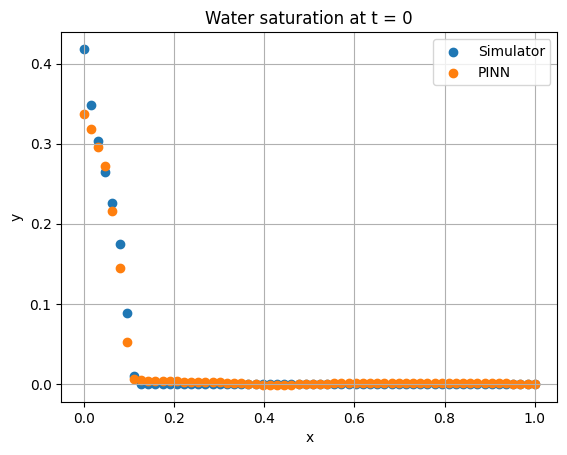

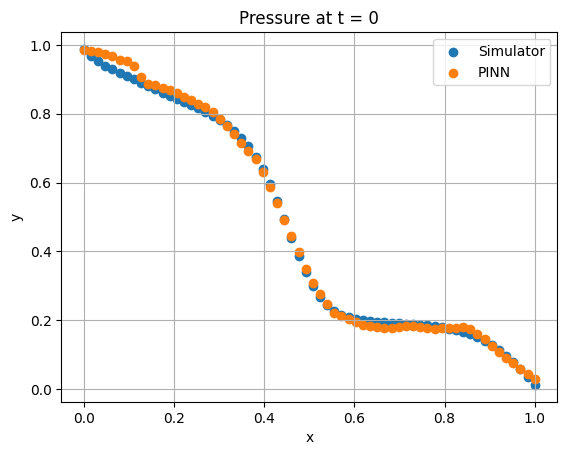

In [85]:
plt.figure()
plt.title('Water saturation at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('swat_scatter_pinn.png')
plt.show()


plt.figure()
plt.title('Pressure at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('pres_scatter_pinn.png')
plt.show()